In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
import numpy as np
import pandas as pd
import math

In [3]:
df =pd.read_csv("/gdrive/Shareddrives/FYP Project/Dataset/FoodData_modified.csv")

In [4]:
dataset = df.drop(labels=['Insulin index', 'Serving Size', 'Acidity (Based on PRAL)', 'Net Carbs ( grams)'], axis = 1)

In [5]:
dataset.dropna(subset = ['Glycemic index'], inplace=True)

In [6]:
dataset = dataset.fillna(0)

In [7]:
dataset['GI Category'] = dataset['GI Category'].map({'low':0, 'medium':1, 'high':2})

In [8]:
target = dataset['GI Category'].values

In [9]:
label_names = {0:'low', 1:'medium', 2:'high'}

In [10]:
train_columns = ["Calories (kcal)", 'Protein (g)','Fats (g)', 'Carbs (g)', 'Fiber (g)', 'Sugar (g)','Phosphorus (mg)', 'Potassium (mg)', 'Sodium (mg)', 'Saturated Fat (g)', 'Trans Fat (g)']

In [11]:
data = dataset[train_columns]

In [12]:
# data standardization
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data = data.values

In [17]:
pip install minisom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for minisom: filename=MiniSom-2.3.0-py3-none-any.whl size=9016 sha256=3be8f9a76b55276f692f127bccfd9fb4546ba9a9c6ec024ea6ebbb25781f8951
  Stored in directory: /root/.cache/pip/wheels/6d/4e/9e/a95c14a232a196c22d9c04b221ff5d25461a1a4c55339c61db
Successfully built minisom


In [42]:
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D

from bokeh.colors import RGB
from bokeh.palettes import Category10, Category20, Category20b, Category20c
from bokeh.io import curdoc, show, output_notebook
from bokeh.transform import factor_mark, factor_cmap
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, output_file

# display matplotlib plots in notebook
%matplotlib inline
# display bokeh plot in notebook
output_notebook()

In [14]:
def plot_graph(som, data, clusters, colours=["red","yellow", "green", "black"]):
  f = plt.figure(figsize=(10,13))
  ax = f.add_subplot(111)

  ax.set_aspect('equal')
  # iteratively add hexagons
  for i in range(weights.shape[0]):
      for j in range(weights.shape[1]):
          wy = yy[(i, j)] * np.sqrt(3) / 2
          hex = RegularPolygon((xx[(i, j)], wy), 
                              numVertices=6, 
                              radius=.95 / np.sqrt(3),
                              facecolor=colours[clusters[i*weights.shape[0] + j ] ], 
                              alpha=.4, 
                              edgecolor='gray')
          ax.add_patch(hex)

  markers = ['o', '+', 'x']
  colors = ['C0', 'C1', 'C2']
  for cnt, x in enumerate(data):
      # getting the winner
      w = som.winner(x)
      # place a marker on the winning position for the sample xx
      wx, wy = som.convert_map_to_euclidean(w) 
      wy = wy * np.sqrt(3) / 2
      plt.plot(wx, wy, 
              markers[target[cnt]-1], 
              markerfacecolor='None',
              markeredgecolor=colors[target[cnt]-1], 
              markersize=12, 
              markeredgewidth=2)

  xrange = np.arange(weights.shape[0])
  yrange = np.arange(weights.shape[1])
  plt.xticks(xrange-.5, xrange)
  plt.yticks(yrange * np.sqrt(3) / 2, yrange)

  divider = make_axes_locatable(plt.gca())
  ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
  cb1 = colorbar.ColorbarBase(ax_cb, cmap=cm.Blues, 
                              orientation='vertical', alpha=.4)
  cb1.ax.get_yaxis().labelpad = 16
  cb1.ax.set_ylabel('distance from neurons in the neighbourhood',
                    rotation=270, fontsize=16)
  plt.gcf().add_axes(ax_cb)

  legend_elements = [Line2D([0], [0], marker='o', color='C0', label='Low',
                    markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                    Line2D([0], [0], marker='+', color='C1', label='Medium',
                    markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                    Line2D([0], [0], marker='x', color='C2', label='High',
                    markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2)]
  ax.legend(handles=legend_elements, bbox_to_anchor=(0.1, 1.08), loc='upper left', 
            borderaxespad=0., ncol=3, fontsize=14)

  plt.show()

In [15]:
def plot_graph_interactive(som, data, clusters, COLOURS=["#ff0000","#ff00ff", "#00ff00", "#ffff11"]):
  hex_centre_col, hex_centre_row = [], []
  hex_colour = []
  label = []

  # define labels
  GI_CATEGORIES = ['Low', 'Medium', 'High']

  for i in range(weights.shape[0]):
      for j in range(weights.shape[1]):
          wy = yy[(i, j)] * np.sqrt(3) / 2
          hex_centre_col.append(xx[(i, j)])
          hex_centre_row.append(wy)
          hex_colour.append(COLOURS[clusters[i*weights.shape[0] + j ] ])

  weight_x, weight_y = [], []
  for cnt, i in enumerate(data):
      w = som.winner(i)
      wx, wy = som.convert_map_to_euclidean(xy=w)
      wy = wy * np.sqrt(3) / 2
      weight_x.append(wx)
      weight_y.append(wy)
      label.append(GI_CATEGORIES[target[cnt]-1])
      
  # convert matplotlib colour palette to bokeh colour palette
  # hex_plt = [(255 * np.array(i)).astype(int) for i in hex_colour]
  hex_bokeh = hex_colour#[RGB(*tuple(rgb)).to_hex() for rgb in hex_plt]

    # initialise figure/plot
  fig = figure(title="SOM: Hexagonal Topology",
              plot_height=800, plot_width=800,
              match_aspect=True,
              tools="wheel_zoom,save,reset")

  # create data stream for plotting
  source_hex = ColumnDataSource(
      data = dict(
          x=hex_centre_col,
          y=hex_centre_row,
          c=hex_bokeh
      )
  )

  source_pages = ColumnDataSource(
      data=dict(
          wx=weight_x,
          wy=weight_y,
          gi_category=label
      )
  )

  # define markers
  MARKERS = ['diamond', 'cross', 'x']

  # add shapes to plot
  fig.hex(x='y', y='x', source=source_hex,
          size=135 * (.95 / np.sqrt(3)) ,
          alpha=.4,
          line_color='gray',
          fill_color='c')

  fig.scatter(x='wy', y='wx', source=source_pages, 
              legend_field='gi_category',
              size=20, 
              marker=factor_mark(field_name='gi_category', markers=MARKERS, factors=GI_CATEGORIES),
              color=factor_cmap(field_name='gi_category', palette='Category10_3', factors=GI_CATEGORIES))

  # add hover-over tooltip
  fig.add_tools(HoverTool(
      tooltips=[
          ("label", '@gi_category'),
          ("(x,y)", '($x, $y)')],
      mode="mouse", 
      point_policy="follow_mouse"
  ))

  show(fig)

In [18]:
# Loading model
import pickle

with open('/gdrive/Shareddrives/FYP Project/Dataset/SOM_Model_Dec5.p', 'rb') as infile:
    som = pickle.load(infile)

In [19]:
xx, yy = som.get_euclidean_coordinates()
umatrix = som.distance_map()
weights = som.get_weights()

In [20]:
temp = []

for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * np.sqrt(3) / 2
        temp.append([xx[(i, j)], wy, umatrix[i, j]])

arr = np.array(temp)

In [23]:
from sklearn.cluster import AffinityPropagation

afPropagationCluster = AffinityPropagation(random_state=5).fit_predict(arr)
afPropagationCluster

array([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  0,  0,  0,  1,
        1,  1,  2,  2,  2,  2,  3,  3,  3,  0,  0,  0,  1,  1,  1,  2,  2,
        2,  3,  3,  3,  3,  4,  4,  0,  4,  5,  5,  5,  5,  2,  6,  3,  6,
        6,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  4,  4,  4,
        8,  8,  8,  5,  9,  9,  9,  6,  6,  6,  4,  7,  7,  8,  8,  8,  8,
        9,  9,  9,  6, 10, 10,  7,  7,  7,  8,  8,  8,  8,  9,  9,  9, 10,
       10, 10,  7,  7,  7,  8,  8,  8,  9,  9,  9,  9, 10, 10, 10])

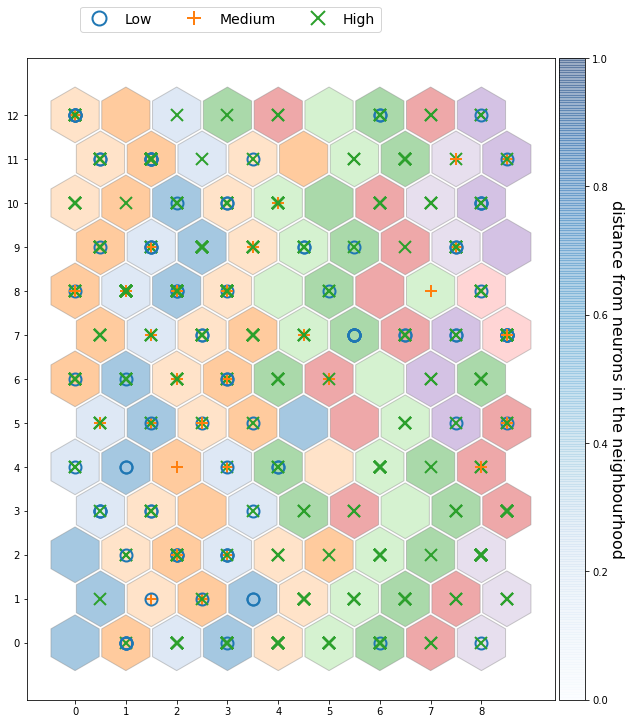

In [40]:
plot_graph(som, data, afPropagationCluster,cm.tab20.colors)

In [44]:
plot_graph_interactive(som, data, afPropagationCluster, Category20[11])

In [48]:
from sklearn.cluster import Birch
brcCluster = Birch(n_clusters=4).fit_predict(arr)
brcCluster

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 3, 3, 3, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 1, 1, 1, 1, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 1, 1, 1, 1, 2, 2, 2, 2, 3, 0, 0, 0, 3, 1,
       1, 1, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [49]:
plot_graph_interactive(som, data, brcCluster, Category20[4])


In [58]:
from sklearn.mixture import GaussianMixture

gmClusterModel = GaussianMixture(n_components=10, random_state=0).fit(arr)

gmCluster = gmClusterModel.predict(arr)
print(gmClusterModel.aic(arr))
print(gmClusterModel.bic(arr))
gmCluster

899.6507489377482
1173.105968482726


array([9, 9, 9, 9, 9, 9, 9, 8, 8, 3, 3, 3, 3, 4, 4, 9, 0, 9, 8, 8, 8, 8,
       3, 3, 3, 3, 4, 4, 0, 0, 0, 0, 8, 8, 8, 3, 3, 6, 3, 4, 4, 4, 0, 0,
       0, 8, 8, 3, 3, 3, 6, 6, 2, 4, 4, 4, 0, 0, 0, 0, 3, 6, 6, 6, 6, 2,
       4, 4, 4, 4, 4, 0, 0, 0, 6, 6, 1, 1, 2, 5, 5, 5, 4, 7, 7, 7, 0, 1,
       1, 1, 1, 2, 2, 5, 5, 4, 4, 7, 7, 1, 1, 1, 1, 1, 2, 2, 5, 5, 5, 5,
       7, 7, 1, 1, 1, 1, 1])

In [60]:
plot_graph_interactive(som, data, gmCluster, Category20[10])

In [ ]:
# som_df.to_csv(r'/gdrive/Shareddrives/FYP Project/Dataset/SOM_FoodData_Nov15.csv')